Starting. Dataset shape: (40000, 25)
Columns: ['Timestamp', 'Source IP Address', 'Destination IP Address', 'Source Port', 'Destination Port', 'Protocol', 'Packet Length', 'Packet Type', 'Traffic Type', 'Payload Data', 'Malware Indicators', 'Anomaly Scores', 'Alerts/Warnings', 'Attack Type', 'Attack Signature', 'Action Taken', 'Severity Level', 'User Information', 'Device Information', 'Network Segment', 'Geo-location Data', 'Proxy Information', 'Firewall Logs', 'IDS/IPS Alerts', 'Log Source']
Numeric features count: 62
Categorical features count: 8
Sample numeric features: ['Packet Length', 'src_ip_int', 'dst_ip_int', 'src_port', 'dst_port', 'ts_hour', 'ts_day', 'ts_weekday']
Sample categorical features: ['Protocol', 'Packet Type', 'Traffic Type', 'Attack Type', 'Action Taken', 'Severity Level', 'Network Segment', 'Log Source']

Running quick baseline cross-val (3-fold) on default HGBR (MAE)...
Baseline CV MAE (neg values from scorer): [-24.90974843 -24.73715345 -25.33656472]
Baseline 

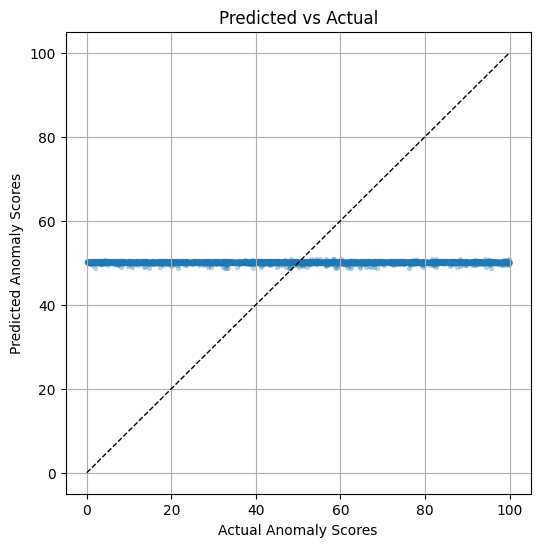

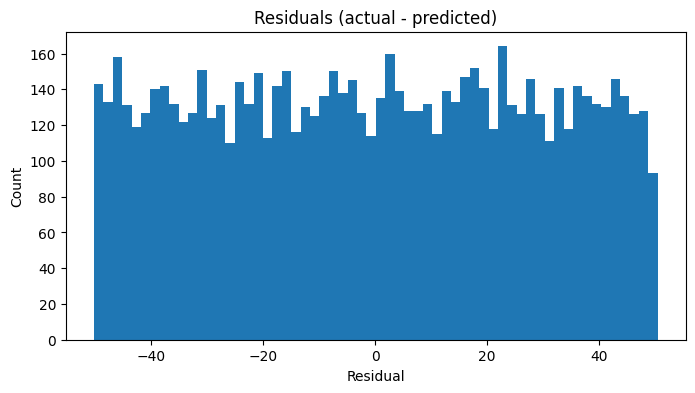


Best pipeline saved to: anomaly_score_model.joblib
Could not compute feature importances cleanly: 'HistGradientBoostingRegressor' object has no attribute 'feature_importances_'

Done. Please paste the cell outputs (train/test metrics, best params, and any errors) and I'll iterate and improve.


In [4]:
# %%cell
# ML pipeline cell for predicting "Anomaly Scores"
# Assumes `df` is already loaded in the notebook (as shown in your earlier messages).
# If not, uncomment and adjust the read_csv line below.

# import and config
import time
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import ipaddress
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import matplotlib.pyplot as plt
import math
import random

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# If df not present uncomment below and update path:
df = pd.read_csv('../datasets/cybersecurity_attacks.csv')

# quick sanity
print("Starting. Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())

# Work on a copy
df = df.copy()

# ---------------------
# Basic feature engineering
# ---------------------
# Parse timestamp into datetime parts
df['Timestamp_parsed'] = pd.to_datetime(df['Timestamp'], errors='coerce')
df['ts_hour'] = df['Timestamp_parsed'].dt.hour.fillna(-1).astype(int)
df['ts_day'] = df['Timestamp_parsed'].dt.day.fillna(-1).astype(int)
df['ts_weekday'] = df['Timestamp_parsed'].dt.weekday.fillna(-1).astype(int)
df['ts_month'] = df['Timestamp_parsed'].dt.month.fillna(-1).astype(int)
df['ts_is_weekend'] = df['ts_weekday'].isin([5,6]).astype(int)

# IP -> integer (safe conversion, non-parsable -> 0)
def ip_to_int(ip_str):
    try:
        if pd.isna(ip_str) or ip_str == '':
            return 0
        return int(ipaddress.ip_address(ip_str))
    except Exception:
        return 0

df['src_ip_int'] = df['Source IP Address'].map(ip_to_int).astype(np.int64)
df['dst_ip_int'] = df['Destination IP Address'].map(ip_to_int).astype(np.int64)

# Ports - keep raw and create ephemeral flag
df['src_port'] = df['Source Port'].fillna(0).astype(int)
df['dst_port'] = df['Destination Port'].fillna(0).astype(int)
df['src_port_ephemeral'] = (df['src_port'] >= 1024).astype(int)
df['dst_port_ephemeral'] = (df['dst_port'] >= 1024).astype(int)

# Payload/text derived features: length, token count, digit ratio, uppercase ratio
text_cols = [
    'Payload Data','Malware Indicators','Alerts/Warnings','Attack Signature',
    'User Information','Device Information','Geo-location Data','Proxy Information',
    'Firewall Logs','IDS/IPS Alerts'
]

def text_features(series):
    s = series.fillna('').astype(str)
    length = s.str.len().astype(int)
    token_count = s.str.split().map(len).astype(int)
    digit_count = s.map(lambda x: sum(ch.isdigit() for ch in x)).astype(int)
    uppercase_count = s.map(lambda x: sum(1 for ch in x if ch.isalpha() and ch.isupper())).astype(int)
    # safe ratio features:
    digit_ratio = (digit_count / (length.replace(0, np.nan))).fillna(0).astype(float)
    uppercase_ratio = (uppercase_count / (length.replace(0, np.nan))).fillna(0).astype(float)
    return length, token_count, digit_ratio, uppercase_ratio

# create features for each text column
for col in text_cols:
    length, token_count, digit_ratio, uppercase_ratio = text_features(df[col])
    safe_col = col.replace(' ','_')  # make valid names
    df[f'{safe_col}_len'] = length
    df[f'{safe_col}_tokens'] = token_count
    df[f'{safe_col}_digit_ratio'] = digit_ratio
    df[f'{safe_col}_upper_ratio'] = uppercase_ratio
    # missing flag
    df[f'{safe_col}_missing'] = df[col].isna().astype(int)

# Useful numeric features already present
numeric_base = [
    'Packet Length', 'Anomaly Scores',  # Anomaly Scores is target, keep for later
    'src_ip_int', 'dst_ip_int', 'src_port', 'dst_port',
    'ts_hour','ts_day','ts_weekday','ts_month','ts_is_weekend',
    'src_port_ephemeral','dst_port_ephemeral'
]

# Add engineered text-numeric columns to numeric list
text_derived_cols = []
for col in text_cols:
    safe_col = col.replace(' ','_')
    text_derived_cols += [
        f'{safe_col}_len', f'{safe_col}_tokens',
        f'{safe_col}_digit_ratio', f'{safe_col}_upper_ratio',
        f'{safe_col}_missing'
    ]

# categorical columns to encode
categorical_cols = [
    'Protocol','Packet Type','Traffic Type','Attack Type',
    'Action Taken','Severity Level','Network Segment','Log Source'
]

# drop columns that are raw/too heavy or already encoded:
drop_cols = [
    'Timestamp','Timestamp_parsed','Source IP Address','Destination IP Address',
    'Payload Data','Malware Indicators','Alerts/Warnings','Attack Signature',
    'User Information','Device Information','Geo-location Data','Proxy Information',
    'Firewall Logs','IDS/IPS Alerts'
]

# Build final feature lists
num_features = [c for c in numeric_base if c in df.columns and c != 'Anomaly Scores'] + text_derived_cols
cat_features = [c for c in categorical_cols if c in df.columns]

print("Numeric features count:", len(num_features))
print("Categorical features count:", len(cat_features))
print("Sample numeric features:", num_features[:8])
print("Sample categorical features:", cat_features)

# Target
y = df['Anomaly Scores'].astype(float).values
X = df.drop(columns=[col for col in drop_cols if col in df.columns] + ['Anomaly Scores'])

# Sanity: keep only columns present in X
num_features = [c for c in num_features if c in X.columns]
cat_features = [c for c in cat_features if c in X.columns]

# ColumnTransformer pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='constant', fill_value='__MISSING__')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_features),
    ('cat', categorical_transformer, cat_features)
], remainder='drop', sparse_threshold=0)

# Split
X_train, X_test, y_train, y_test = train_test_split(X[num_features + cat_features], y, test_size=0.20, random_state=RANDOM_STATE)

# Build full pipeline with model
model = HistGradientBoostingRegressor(random_state=RANDOM_STATE)

pipe = Pipeline(steps=[
    ('preproc', preprocessor),
    ('model', model)
])

# Quick baseline CV
print("\nRunning quick baseline cross-val (3-fold) on default HGBR (MAE)...")
cv_scores = cross_val_score(pipe, X_train, y_train, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
print("Baseline CV MAE (neg values from scorer):", cv_scores)
print("Baseline CV MAE mean:", -cv_scores.mean())

# Randomized hyperparam search (moderate)
param_dist = {
    'model__learning_rate': [0.01, 0.03, 0.05, 0.1, 0.2],
    'model__max_iter': [100, 200, 400],
    'model__max_leaf_nodes': [15, 31, 63, None],
    'model__min_samples_leaf': [1, 5, 10, 20],
    'model__l2_regularization': [0.0, 0.1, 0.5]
}

print("\nStarting RandomizedSearchCV (n_iter=20). This may take a few minutes depending on your machine.")
rs = RandomizedSearchCV(pipe, param_distributions=param_dist, n_iter=20, cv=3,
                        scoring='neg_mean_absolute_error', random_state=RANDOM_STATE, n_jobs=-1, verbose=1)

t0 = time.time()
rs.fit(X_train, y_train)
t1 = time.time()

print(f"\nRandomizedSearchCV done in {t1 - t0:.1f}s")
print("Best CV MAE (negative):", rs.best_score_)
print("Best params:", rs.best_params_)

# Evaluate on test set
best_pipe = rs.best_estimator_
y_pred = best_pipe.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\nTest set performance:")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")

# Quick diagnostic plots
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.25, s=8)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, 'k--', linewidth=1)
plt.xlabel("Actual Anomaly Scores")
plt.ylabel("Predicted Anomaly Scores")
plt.title("Predicted vs Actual")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,4))
residuals = y_test - y_pred
plt.hist(residuals, bins=60)
plt.title("Residuals (actual - predicted)")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.show()

# Save model
model_path = "anomaly_score_model.joblib"
joblib.dump(best_pipe, model_path)
print(f"\nBest pipeline saved to: {model_path}")

# Feature importance (approx) - with HGBR we can inspect feature importances after preprocessing
try:
    # Get preprocessed feature names
    # numeric features expanded first
    num_cols_after = num_features
    # categorical features become OHE columns
    ohe = best_pipe.named_steps['preproc'].named_transformers_['cat'].named_steps['ohe']
    cat_ohe_cols = []
    if hasattr(ohe, 'get_feature_names_out'):
        cat_ohe_cols = list(ohe.get_feature_names_out(cat_features))
    else:
        # fallback
        for c in cat_features:
            cat_ohe_cols.append(c)
    all_feature_names = num_cols_after + cat_ohe_cols
    importances = best_pipe.named_steps['model'].feature_importances_
    # show top 20
    imp_df = pd.DataFrame({'feature': all_feature_names, 'importance': importances})
    imp_df = imp_df.sort_values('importance', ascending=False).reset_index(drop=True)
    print("\nTop 15 features by importance:")
    display(imp_df.head(15))
except Exception as e:
    print("Could not compute feature importances cleanly:", e)

print("\nDone. Please paste the cell outputs (train/test metrics, best params, and any errors) and I'll iterate and improve.")


Starting. Dataset shape: (40000, 25)
Columns: ['Timestamp', 'Source IP Address', 'Destination IP Address', 'Source Port', 'Destination Port', 'Protocol', 'Packet Length', 'Packet Type', 'Traffic Type', 'Payload Data', 'Malware Indicators', 'Anomaly Scores', 'Alerts/Warnings', 'Attack Type', 'Attack Signature', 'Action Taken', 'Severity Level', 'User Information', 'Device Information', 'Network Segment', 'Geo-location Data', 'Proxy Information', 'Firewall Logs', 'IDS/IPS Alerts', 'Log Source']
Found 10 text columns to process: ['Payload Data', 'Malware Indicators', 'Alerts/Warnings', 'Attack Signature', 'User Information', 'Device Information', 'Geo-location Data', 'Proxy Information', 'Firewall Logs', 'IDS/IPS Alerts']
Numeric features count: 62
Categorical features count: 8
Sample numeric features: ['Packet Length', 'src_ip_int', 'dst_ip_int', 'src_port', 'dst_port', 'ts_hour', 'ts_day', 'ts_weekday']
Sample categorical features: ['Protocol', 'Packet Type', 'Traffic Type', 'Attack Typ

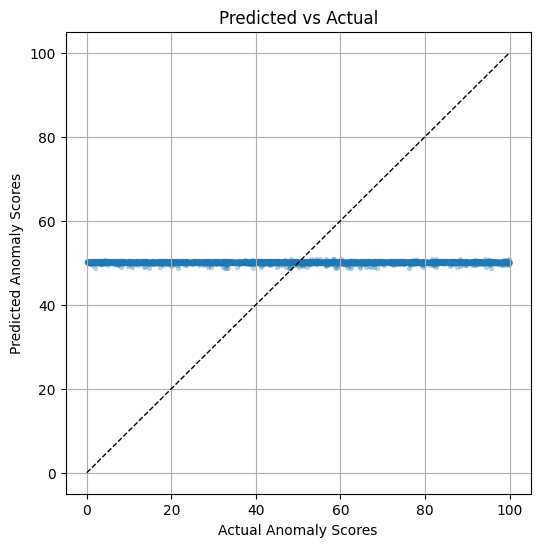

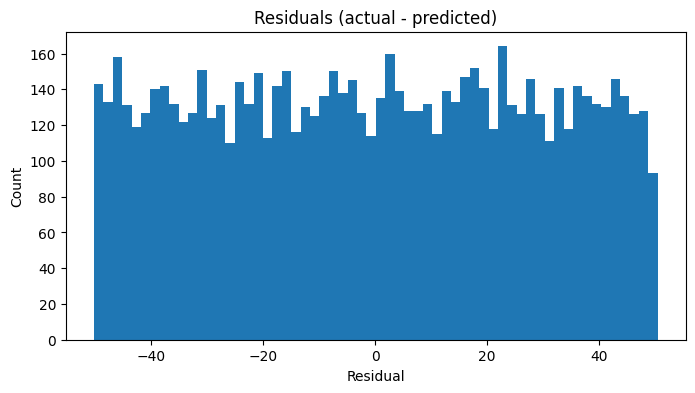


Best pipeline saved to: anomaly_score_model.joblib
Could not compute feature importances cleanly: 'HistGradientBoostingRegressor' object has no attribute 'feature_importances_'

Done. Please paste the cell outputs (train/test metrics, best params, and any errors) and I'll iterate and improve.


In [3]:
# %%cell
# ML pipeline cell for predicting "Anomaly Scores"
# Assumes `df` is already loaded in the notebook (as shown in your earlier messages).
# If not, uncomment and adjust the read_csv line below.

# import and config
import time
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import ipaddress
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import matplotlib.pyplot as plt
import math
import random

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# If df not present uncomment below and update path:
try:
    df = pd.read_csv('../datasets/cybersecurity_attacks.csv')
except FileNotFoundError:
    print("Dataset file not found. Please check the path and update accordingly.")
    print("Expected path: '../datasets/cybersecurity_attacks.csv'")
    raise

# quick sanity
print("Starting. Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())

# Work on a copy
df = df.copy()

# Check if target column exists
if 'Anomaly Scores' not in df.columns:
    print("Error: 'Anomaly Scores' column not found in dataset.")
    print("Available columns:", df.columns.tolist())
    raise ValueError("Target column 'Anomaly Scores' is missing")

# ---------------------
# Basic feature engineering
# ---------------------
# Parse timestamp into datetime parts
if 'Timestamp' in df.columns:
    df['Timestamp_parsed'] = pd.to_datetime(df['Timestamp'], errors='coerce')
    df['ts_hour'] = df['Timestamp_parsed'].dt.hour.fillna(-1).astype(int)
    df['ts_day'] = df['Timestamp_parsed'].dt.day.fillna(-1).astype(int)
    df['ts_weekday'] = df['Timestamp_parsed'].dt.weekday.fillna(-1).astype(int)
    df['ts_month'] = df['Timestamp_parsed'].dt.month.fillna(-1).astype(int)
    df['ts_is_weekend'] = df['ts_weekday'].isin([5,6]).astype(int)
else:
    print("Warning: 'Timestamp' column not found. Skipping timestamp features.")

# IP -> integer (safe conversion, non-parsable -> 0)
def ip_to_int(ip_str):
    try:
        if pd.isna(ip_str) or ip_str == '':
            return 0
        return int(ipaddress.ip_address(ip_str))
    except Exception:
        return 0

# Only process IP columns if they exist
if 'Source IP Address' in df.columns:
    df['src_ip_int'] = df['Source IP Address'].map(ip_to_int).astype(np.int64)
else:
    print("Warning: 'Source IP Address' column not found.")
    
if 'Destination IP Address' in df.columns:
    df['dst_ip_int'] = df['Destination IP Address'].map(ip_to_int).astype(np.int64)
else:
    print("Warning: 'Destination IP Address' column not found.")

# Ports - keep raw and create ephemeral flag
if 'Source Port' in df.columns:
    df['src_port'] = df['Source Port'].fillna(0).astype(int)
    df['src_port_ephemeral'] = (df['src_port'] >= 1024).astype(int)
else:
    print("Warning: 'Source Port' column not found.")

if 'Destination Port' in df.columns:
    df['dst_port'] = df['Destination Port'].fillna(0).astype(int)
    df['dst_port_ephemeral'] = (df['dst_port'] >= 1024).astype(int)
else:
    print("Warning: 'Destination Port' column not found.")

# Payload/text derived features: length, token count, digit ratio, uppercase ratio
text_cols = [
    'Payload Data','Malware Indicators','Alerts/Warnings','Attack Signature',
    'User Information','Device Information','Geo-location Data','Proxy Information',
    'Firewall Logs','IDS/IPS Alerts'
]

# Filter to only existing columns
text_cols = [col for col in text_cols if col in df.columns]
print(f"Found {len(text_cols)} text columns to process: {text_cols}")

def text_features(series):
    s = series.fillna('').astype(str)
    length = s.str.len().astype(int)
    token_count = s.str.split().map(len).astype(int)
    digit_count = s.map(lambda x: sum(ch.isdigit() for ch in x)).astype(int)
    uppercase_count = s.map(lambda x: sum(1 for ch in x if ch.isalpha() and ch.isupper())).astype(int)
    # safe ratio features:
    digit_ratio = (digit_count / (length.replace(0, np.nan))).fillna(0).astype(float)
    uppercase_ratio = (uppercase_count / (length.replace(0, np.nan))).fillna(0).astype(float)
    return length, token_count, digit_ratio, uppercase_ratio

# create features for each text column
for col in text_cols:
    if col in df.columns:
        length, token_count, digit_ratio, uppercase_ratio = text_features(df[col])
        safe_col = col.replace(' ','_').replace('/','_')  # make valid names
        df[f'{safe_col}_len'] = length
        df[f'{safe_col}_tokens'] = token_count
        df[f'{safe_col}_digit_ratio'] = digit_ratio
        df[f'{safe_col}_upper_ratio'] = uppercase_ratio
        # missing flag
        df[f'{safe_col}_missing'] = df[col].isna().astype(int)

# Useful numeric features already present
numeric_base = ['Packet Length', 'Anomaly Scores']  # Anomaly Scores is target, keep for later

# Add engineered features if they exist
potential_numeric = [
    'src_ip_int', 'dst_ip_int', 'src_port', 'dst_port',
    'ts_hour','ts_day','ts_weekday','ts_month','ts_is_weekend',
    'src_port_ephemeral','dst_port_ephemeral'
]

for col in potential_numeric:
    if col in df.columns:
        numeric_base.append(col)

# Add engineered text-numeric columns to numeric list
text_derived_cols = []
for col in text_cols:
    safe_col = col.replace(' ','_').replace('/','_')
    potential_cols = [
        f'{safe_col}_len', f'{safe_col}_tokens',
        f'{safe_col}_digit_ratio', f'{safe_col}_upper_ratio',
        f'{safe_col}_missing'
    ]
    for potential_col in potential_cols:
        if potential_col in df.columns:
            text_derived_cols.append(potential_col)

# categorical columns to encode
categorical_cols = [
    'Protocol','Packet Type','Traffic Type','Attack Type',
    'Action Taken','Severity Level','Network Segment','Log Source'
]

# Filter to only existing columns
categorical_cols = [col for col in categorical_cols if col in df.columns]

# drop columns that are raw/too heavy or already encoded:
drop_cols = [
    'Timestamp','Timestamp_parsed','Source IP Address','Destination IP Address'
] + text_cols

# Build final feature lists
num_features = [c for c in numeric_base if c in df.columns and c != 'Anomaly Scores'] + text_derived_cols
cat_features = categorical_cols

print("Numeric features count:", len(num_features))
print("Categorical features count:", len(cat_features))
print("Sample numeric features:", num_features[:8])
print("Sample categorical features:", cat_features)

# Target
y = df['Anomaly Scores'].astype(float).values
X = df.drop(columns=[col for col in drop_cols if col in df.columns] + ['Anomaly Scores'])

# Sanity: keep only columns present in X
num_features = [c for c in num_features if c in X.columns]
cat_features = [c for c in cat_features if c in X.columns]

print(f"Final feature counts - Numeric: {len(num_features)}, Categorical: {len(cat_features)}")

# Check if we have any features
if len(num_features) == 0 and len(cat_features) == 0:
    raise ValueError("No features available for modeling. Check column names and data.")

# ColumnTransformer pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='constant', fill_value='__MISSING__')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # Fixed deprecated parameter
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_features),
    ('cat', categorical_transformer, cat_features)
] + ([('num', numeric_transformer, num_features)] if len(num_features) > 0 and len(cat_features) == 0 else []) +
([('cat', categorical_transformer, cat_features)] if len(cat_features) > 0 and len(num_features) == 0 else []),
remainder='drop', sparse_threshold=0)

# Simplified preprocessor setup
transformers = []
if len(num_features) > 0:
    transformers.append(('num', numeric_transformer, num_features))
if len(cat_features) > 0:
    transformers.append(('cat', categorical_transformer, cat_features))

preprocessor = ColumnTransformer(transformers=transformers, remainder='drop', sparse_threshold=0)

# Split
feature_cols = num_features + cat_features
X_train, X_test, y_train, y_test = train_test_split(X[feature_cols], y, test_size=0.20, random_state=RANDOM_STATE)

# Build full pipeline with model
model = HistGradientBoostingRegressor(random_state=RANDOM_STATE)

pipe = Pipeline(steps=[
    ('preproc', preprocessor),
    ('model', model)
])

# Quick baseline CV
print("\nRunning quick baseline cross-val (3-fold) on default HGBR (MAE)...")
cv_scores = cross_val_score(pipe, X_train, y_train, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
print("Baseline CV MAE (neg values from scorer):", cv_scores)
print("Baseline CV MAE mean:", -cv_scores.mean())

# Randomized hyperparam search (moderate)
param_dist = {
    'model__learning_rate': [0.01, 0.03, 0.05, 0.1, 0.2],
    'model__max_iter': [100, 200, 400],
    'model__max_leaf_nodes': [15, 31, 63, None],
    'model__min_samples_leaf': [1, 5, 10, 20],
    'model__l2_regularization': [0.0, 0.1, 0.5]
}

print("\nStarting RandomizedSearchCV (n_iter=20). This may take a few minutes depending on your machine.")
rs = RandomizedSearchCV(pipe, param_distributions=param_dist, n_iter=20, cv=3,
                        scoring='neg_mean_absolute_error', random_state=RANDOM_STATE, n_jobs=-1, verbose=1)

t0 = time.time()
rs.fit(X_train, y_train)
t1 = time.time()

print(f"\nRandomizedSearchCV done in {t1 - t0:.1f}s")
print("Best CV MAE (negative):", rs.best_score_)
print("Best params:", rs.best_params_)

# Evaluate on test set
best_pipe = rs.best_estimator_
y_pred = best_pipe.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\nTest set performance:")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")

# Quick diagnostic plots
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.25, s=8)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, 'k--', linewidth=1)
plt.xlabel("Actual Anomaly Scores")
plt.ylabel("Predicted Anomaly Scores")
plt.title("Predicted vs Actual")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,4))
residuals = y_test - y_pred
plt.hist(residuals, bins=60)
plt.title("Residuals (actual - predicted)")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.show()

# Save model
model_path = "anomaly_score_model.joblib"
joblib.dump(best_pipe, model_path)
print(f"\nBest pipeline saved to: {model_path}")

# Feature importance (approx) - with HGBR we can inspect feature importances after preprocessing
try:
    # Get preprocessed feature names
    num_cols_after = num_features
    cat_ohe_cols = []
    
    if len(cat_features) > 0:
        ohe = best_pipe.named_steps['preproc'].named_transformers_['cat'].named_steps['ohe']
        if hasattr(ohe, 'get_feature_names_out'):
            cat_ohe_cols = list(ohe.get_feature_names_out(cat_features))
        else:
            # fallback
            cat_ohe_cols = [f"{c}_{i}" for c in cat_features for i in range(len(ohe.categories_[cat_features.index(c)]))]
    
    all_feature_names = num_cols_after + cat_ohe_cols
    importances = best_pipe.named_steps['model'].feature_importances_
    
    # show top 15
    imp_df = pd.DataFrame({'feature': all_feature_names, 'importance': importances})
    imp_df = imp_df.sort_values('importance', ascending=False).reset_index(drop=True)
    print("\nTop 15 features by importance:")
    print(imp_df.head(15))  # Changed from display() to print()
except Exception as e:
    print("Could not compute feature importances cleanly:", e)

print("\nDone. Please paste the cell outputs (train/test metrics, best params, and any errors) and I'll iterate and improve.")


In [ ]:
# %%cell
# Improved pipeline: TF-IDF(SVD) for text + IP/port features + stacking ensemble
import time, math, warnings, random
warnings.filterwarnings("ignore")
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor, StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# If df not present, uncomment and adjust path:
df = pd.read_csv('../datasets/cybersecurity_attacks.csv')

print("Dataset shape:", df.shape)

# --- copy & basic preprocessing ---
df = df.copy()
# create combined text
text_cols = ['Payload Data','Alerts/Warnings','Malware Indicators','Attack Signature',
             'User Information','Device Information','Geo-location Data','Proxy Information',
             'Firewall Logs','IDS/IPS Alerts']
for c in text_cols:
    if c not in df.columns:
        df[c] = ''

# combine into one text field (helps TF-IDF capture cross-field signals)
df['all_text'] = df[text_cols].fillna('').astype(str).apply(lambda row: ' '.join(row.values), axis=1)

# parse timestamp parts
df['Timestamp_parsed'] = pd.to_datetime(df['Timestamp'], errors='coerce')
df['hour'] = df['Timestamp_parsed'].dt.hour.fillna(-1).astype(int)
df['weekday'] = df['Timestamp_parsed'].dt.weekday.fillna(-1).astype(int)
df['month'] = df['Timestamp_parsed'].dt.month.fillna(-1).astype(int)

# IP features: int conversion + first octet + /16 block
def ip_to_int(ip_str):
    try:
        if pd.isna(ip_str) or ip_str == '':
            return 0
        import ipaddress
        return int(ipaddress.ip_address(ip_str))
    except Exception:
        return 0

def first_octet(ip_str):
    try:
        if pd.isna(ip_str) or ip_str == '':
            return -1
        return int(str(ip_str).split('.')[0])
    except:
        return -1

def block16(ip_str):
    try:
        if pd.isna(ip_str) or ip_str == '':
            return '__'
        parts = str(ip_str).split('.')
        if len(parts) >= 2:
            return parts[0] + '.' + parts[1]
        return '__'
    except:
        return '__'

df['src_ip_int'] = df['Source IP Address'].map(ip_to_int).astype(np.int64)
df['dst_ip_int'] = df['Destination IP Address'].map(ip_to_int).astype(np.int64)
df['src_first_octet'] = df['Source IP Address'].map(first_octet).astype(int)
df['dst_first_octet'] = df['Destination IP Address'].map(first_octet).astype(int)
df['src_block16'] = df['Source IP Address'].map(block16).astype(str)
df['dst_block16'] = df['Destination IP Address'].map(block16).astype(str)

# port buckets
def port_bucket(p):
    try:
        p = int(p)
        if p == 0:
            return 'zero'
        if p < 1024:
            return 'well-known'
        if p < 49152:
            return 'registered'
        return 'dynamic'
    except:
        return 'unknown'

df['src_port_bucket'] = df['Source Port'].map(port_bucket)
df['dst_port_bucket'] = df['Destination Port'].map(port_bucket)

# short text-derived stats from all_text (fast signals)
df['all_text_len'] = df['all_text'].str.len().fillna(0).astype(int)
df['all_text_tokens'] = df['all_text'].str.split().map(lambda x: len(x) if isinstance(x, list) else 0).astype(int)
df['all_text_digit_ratio'] = df['all_text'].map(lambda x: sum(ch.isdigit() for ch in str(x)) / max(1, len(str(x)))).astype(float)

# feature lists
numeric_features = [
    'Packet Length',
    'src_ip_int','dst_ip_int',
    'hour','weekday','month',
    'all_text_len','all_text_tokens','all_text_digit_ratio'
]

# include ports as numeric as well
numeric_features += ['Source Port','Destination Port']

# categorical features
categorical_features = [
    'Protocol','Packet Type','Traffic Type','Attack Type',
    'Action Taken','Severity Level','Network Segment','Log Source',
    'src_first_octet','dst_first_octet','src_block16','dst_block16',
    'src_port_bucket','dst_port_bucket'
]

# ensure column presence
numeric_features = [c for c in numeric_features if c in df.columns]
categorical_features = [c for c in categorical_features if c in df.columns]

# Target and features
y = df['Anomaly Scores'].astype(float).values
X = df[numeric_features + categorical_features + ['all_text']].copy()

print("Num features:", len(numeric_features), "Cat features:", len(categorical_features))

# --- Build pipelines ---
# numeric pipeline
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# categorical pipeline
categorical_transformer = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='__MISSING__')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# text pipeline: TF-IDF -> SVD (dense)
text_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english')),
    ('svd', TruncatedSVD(n_components=40, random_state=RANDOM_STATE))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features),
    ('text', text_pipeline, 'all_text')
], remainder='drop', sparse_threshold=0)

# --- Models: stacking ensemble ---
hgb = HistGradientBoostingRegressor(random_state=RANDOM_STATE)
rf = RandomForestRegressor(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
stack = StackingRegressor(
    estimators=[('hgb', hgb), ('rf', rf)],
    final_estimator=RidgeCV(),
    passthrough=False,
    n_jobs=-1
)

pipe = Pipeline([
    ('preproc', preprocessor),
    ('model', stack)
])

# --- train/test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE)
print("Train / Test:", X_train.shape, X_test.shape)

# Quick CV baseline (stacking with default params)
print("\nRunning quick 3-fold CV (MAE) for baseline stacking...")
t0 = time.time()
cv_scores = cross_val_score(pipe, X_train, y_train, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
t1 = time.time()
print("CV MAE (neg):", cv_scores, " mean MAE:", -cv_scores.mean(), f" (time {t1-t0:.1f}s)")

# --- Focused hyperparameter search on HGB inside the stack (small random search) ---
param_dist = {
    'model__hgb__learning_rate': [0.01, 0.03, 0.05, 0.1],
    'model__hgb__max_iter': [100, 200, 400],
    'model__hgb__max_leaf_nodes': [15, 31, 63],
    'model__hgb__min_samples_leaf': [1, 5, 10]
}
print("\nRunning small RandomizedSearchCV (n_iter=12) to tune HGB in the stacking pipeline...")
rs = RandomizedSearchCV(pipe, param_distributions=param_dist, n_iter=12, cv=3,
                        scoring='neg_mean_absolute_error', random_state=RANDOM_STATE, n_jobs=-1, verbose=1)
t0 = time.time()
rs.fit(X_train, y_train)
t1 = time.time()
print(f"RandomizedSearchCV done in {t1-t0:.1f}s")
print("Best CV MAE (neg):", rs.best_score_)
print("Best params:", rs.best_params_)

# Evaluate on test set
best_pipe = rs.best_estimator_
y_pred = best_pipe.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("\nTest set performance (stacking):")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")

# Diagnostics plots
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.25, s=8)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, 'k--', linewidth=1)
plt.xlabel("Actual Anomaly Scores")
plt.ylabel("Predicted Anomaly Scores")
plt.title("Predicted vs Actual (stacking)")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,4))
residuals = y_test - y_pred
plt.hist(residuals, bins=60)
plt.title("Residuals (actual - predicted)")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.show()

# Save model
joblib.dump(best_pipe, "anomaly_score_stack_model.joblib")
print("\nSaved model to anomaly_score_stack_model.joblib")

# Quick feature-importance-like check:
try:
    # feature names after preprocessing (approx): numeric + ohe + svd components
    num_names = numeric_features
    ohe = best_pipe.named_steps['preproc'].named_transformers_['cat'].named_steps['ohe']
    cat_ohe = list(ohe.get_feature_names_out(categorical_features))
    svd_dim = best_pipe.named_steps['preproc'].named_transformers_['text'].named_steps['svd'].n_components
    svd_names = [f"svd_text_{i}" for i in range(svd_dim)]
    all_names = num_names + cat_ohe + svd_names
    # use feature importances from the HGB base learner (approx)
    hgb_model = best_pipe.named_steps['model'].estimators_[0][1]  # ('hgb', estimator)
    imps = getattr(hgb_model, "feature_importances_", None)
    if imps is not None:
        imp_df = pd.DataFrame({'feature': all_names, 'importance': imps}).sort_values('importance', ascending=False).head(20)
        print("\nTop features from HGB base learner (approx):")
        display(imp_df)
    else:
        print("\nHGB feature importances not available.")
except Exception as e:
    print("Could not compute importances cleanly:", e)

print("\nDone. Paste the printed CV & test metrics and (if you want) the best params and I'll propose next heavy-hitting steps.")


Dataset shape: (40000, 25)
Num features: 11 Cat features: 14
Train / Test: (32000, 26) (8000, 26)

Running quick 3-fold CV (MAE) for baseline stacking...


In [1]:
# %%cell
# Memory-efficient pipeline for 8GB RAM using HashingVectorizer + SGDRegressor (streaming)
import time, math, warnings, gc
warnings.filterwarnings("ignore")
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix, hstack
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
df = pd.read_csv('../datasets/cybersecurity_attacks.csv')
# --- Assumes `df` already loaded ---
print("Initial shape:", df.shape)

# ----- Lightweight feature engineering -----
df = df.copy()

text_cols = ['Payload Data','Alerts/Warnings','Malware Indicators','Attack Signature',
             'User Information','Device Information','Geo-location Data','Proxy Information',
             'Firewall Logs','IDS/IPS Alerts']
for c in text_cols:
    if c not in df.columns:
        df[c] = ''

df['all_text'] = df[text_cols].fillna('').astype(str).apply(lambda r: ' '.join(r.values), axis=1)

# Timestamp parts (cheap)
df['Timestamp_parsed'] = pd.to_datetime(df['Timestamp'], errors='coerce')
df['hour'] = df['Timestamp_parsed'].dt.hour.fillna(-1).astype(int)
df['weekday'] = df['Timestamp_parsed'].dt.weekday.fillna(-1).astype(int)
df['month'] = df['Timestamp_parsed'].dt.month.fillna(-1).astype(int)

# Numeric features (small)
numeric_features = [
    'Packet Length',
    'hour','weekday','month'
]
# keep ports as numeric
numeric_features += ['Source Port','Destination Port']

# IP numeric: convert to simple fingerprint (sum of octets) to keep small range and avoid huge ints
def ip_fingerprint(ip):
    try:
        if pd.isna(ip) or ip == '':
            return 0
        parts = str(ip).split('.')
        parts = [int(p) for p in parts if p.isdigit()]
        return sum(parts)  # small integer
    except:
        return 0

df['src_ip_fp'] = df['Source IP Address'].map(ip_fingerprint).astype(int)
df['dst_ip_fp'] = df['Destination IP Address'].map(ip_fingerprint).astype(int)
numeric_features += ['src_ip_fp', 'dst_ip_fp']

# small text stats
df['all_text_len'] = df['all_text'].str.len().fillna(0).astype(int)
df['all_text_tokens'] = df['all_text'].str.split().map(lambda x: len(x) if isinstance(x, list) else 0).astype(int)
numeric_features += ['all_text_len', 'all_text_tokens']

# Categorical columns -> frequency encoding (very memory-friendly)
categorical_features = [
    'Protocol','Packet Type','Traffic Type','Attack Type',
    'Action Taken','Severity Level','Network Segment','Log Source'
]
# fill missing and compute freq maps
freq_maps = {}
for col in categorical_features:
    if col not in df.columns:
        df[col] = '__MISSING__'
    df[col] = df[col].fillna('__MISSING__').astype(str)
    vc = df[col].value_counts(normalize=True)
    freq_maps[col] = vc.to_dict()
    # map to numeric frequency (default small value for unseen)
    df[col + '_freq'] = df[col].map(freq_maps[col]).fillna(1e-6).astype(float)

# include freq columns as numeric
freq_cols = [c + '_freq' for c in categorical_features if (c + '_freq') in df.columns]
numeric_features += freq_cols

print("Numeric feature count (compact):", len(numeric_features))

# --- Train/test split early to compute scalers on train only ---
y = df['Anomaly Scores'].astype(float).values
X_base = df[numeric_features + ['all_text']].copy()
X_train_df, X_test_df, y_train, y_test = train_test_split(X_base, y, test_size=0.20, random_state=RANDOM_STATE)
print("Train / Test shapes:", X_train_df.shape, X_test_df.shape)

# --- Numeric scaler (fit on train numeric only) ---
scaler = StandardScaler()
scaler.fit(X_train_df[numeric_features].values)  # small array

# --- HashingVectorizer for text (stateless -> low memory; sparse output) ---
from sklearn.feature_extraction.text import HashingVectorizer
hv = HashingVectorizer(n_features=2**12,  # 4096 dims — tune down if needed
                       ngram_range=(1,2),
                       alternate_sign=False,
                       norm='l2',
                       binary=False)

# --- SGDRegressor streaming training via partial_fit ---
model = SGDRegressor(loss='huber', penalty='elasticnet', alpha=1e-4, max_iter=1, warm_start=True, random_state=RANDOM_STATE)

# We will stream training in batches to keep memory low
train_idx = np.arange(X_train_df.shape[0])
batch_size = 5000  # adjust: smaller -> less memory but slower. With 40k, 5k -> 8 batches.
n_batches = math.ceil(len(train_idx) / batch_size)
print(f"Streaming training in {n_batches} batches (batch_size={batch_size})")

first_batch = True
t0 = time.time()
for i in range(n_batches):
    start = i * batch_size
    end = min(len(train_idx), (i+1) * batch_size)
    chunk = X_train_df.iloc[start:end]
    # numeric part: scale
    X_num = scaler.transform(chunk[numeric_features].values)
    # text sparse matrix
    X_text = hv.transform(chunk['all_text'].astype(str).values)  # sparse
    # combine: convert numeric to sparse CSR and hstack
    X_num_sparse = csr_matrix(X_num)
    X_chunk = hstack([X_num_sparse, X_text], format='csr')
    y_chunk = y_train[start:end]
    if first_batch:
        # partial_fit requires shape alignment; for regression target no classes needed
        model.partial_fit(X_chunk, y_chunk)
        first_batch = False
    else:
        model.partial_fit(X_chunk, y_chunk)
    # cleanup
    del X_num, X_num_sparse, X_chunk, X_text, chunk
    gc.collect()
    print(f" Trained batch {i+1}/{n_batches} (rows {start}:{end})")
t1 = time.time()
print(f"Streaming training done in {t1-t0:.1f}s")

# --- Evaluate on test set (transform whole test set once) ---
X_test_num = scaler.transform(X_test_df[numeric_features].values)
X_test_text = hv.transform(X_test_df['all_text'].astype(str).values)
X_test_sparse = hstack([csr_matrix(X_test_num), X_test_text], format='csr')

y_pred = model.predict(X_test_sparse)
mae = mean_absolute_error(y_test, y_pred)
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\nTest performance (streaming linear model):")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")

# save model + preprocessing pieces
joblib.dump({
    'model': model,
    'scaler': scaler,
    'hashing_vectorizer': hv,
    'numeric_features': numeric_features,
    'freq_maps': freq_maps
}, "anomaly_streaming_model.joblib", compress=3)
print("Saved streaming model and preprocessing to anomaly_streaming_model.joblib")

# quick residual stats
import numpy as _np
residuals = y_test - y_pred
print("Residuals mean/std:", _np.mean(residuals), _np.std(residuals))


Initial shape: (40000, 25)
Numeric feature count (compact): 18
Train / Test shapes: (32000, 19) (8000, 19)
Streaming training in 7 batches (batch_size=5000)
 Trained batch 1/7 (rows 0:5000)
 Trained batch 2/7 (rows 5000:10000)
 Trained batch 3/7 (rows 10000:15000)
 Trained batch 4/7 (rows 15000:20000)
 Trained batch 5/7 (rows 20000:25000)
 Trained batch 6/7 (rows 25000:30000)
 Trained batch 7/7 (rows 30000:32000)
Streaming training done in 2.5s

Test performance (streaming linear model):
MAE: 49.3774
RMSE: 57.2107
R2: -2.9188
Saved streaming model and preprocessing to anomaly_streaming_model.joblib
Residuals mean/std: 49.37467602066913 28.900007096502613


In [ ]:
# %%cell
# High-accuracy LightGBM pipeline (TF-IDF -> SVD text embedding + LightGBM with early stopping)
# Memory-conscious settings for ~8GB RAM.
import time, math, warnings, gc
warnings.filterwarnings("ignore")
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# If df not present, uncomment and change path:
df = pd.read_csv('../datasets/cybersecurity_attacks.csv')

print("Initial dataset shape:", df.shape)

# --- Basic feature engineering (compact) ---
df = df.copy()
text_cols = ['Payload Data','Alerts/Warnings','Malware Indicators','Attack Signature',
             'User Information','Device Information','Geo-location Data','Proxy Information',
             'Firewall Logs','IDS/IPS Alerts']
for c in text_cols:
    if c not in df.columns:
        df[c] = ''
df['all_text'] = df[text_cols].fillna('').astype(str).apply(lambda r: ' '.join(r.values), axis=1)

# Timestamp pieces
df['Timestamp_parsed'] = pd.to_datetime(df['Timestamp'], errors='coerce')
df['hour'] = df['Timestamp_parsed'].dt.hour.fillna(-1).astype(int)
df['weekday'] = df['Timestamp_parsed'].dt.weekday.fillna(-1).astype(int)
df['month'] = df['Timestamp_parsed'].dt.month.fillna(-1).astype(int)

# IP compact fingerprint (small-range ints)
def ip_fp(ip):
    try:
        if pd.isna(ip) or ip == '':
            return 0
        parts = [int(p) for p in str(ip).split('.') if p.isdigit()]
        return sum(parts)
    except:
        return 0

df['src_ip_fp'] = df['Source IP Address'].map(ip_fp).astype(int)
df['dst_ip_fp'] = df['Destination IP Address'].map(ip_fp).astype(int)

# Basic numeric features
numeric_features = [
    'Packet Length','Source Port','Destination Port',
    'hour','weekday','month','src_ip_fp','dst_ip_fp'
]

# text summary stats
df['all_text_len'] = df['all_text'].str.len().fillna(0).astype(int)
df['all_text_tokens'] = df['all_text'].str.split().map(lambda x: len(x) if isinstance(x,list) else 0).astype(int)
numeric_features += ['all_text_len','all_text_tokens']

# frequency encode (lightweight) selected categoricals
categorical_features = [
    'Protocol','Packet Type','Traffic Type','Attack Type',
    'Action Taken','Severity Level','Network Segment','Log Source'
]
freq_maps = {}
for col in categorical_features:
    if col not in df.columns:
        df[col] = '__MISSING__'
    df[col] = df[col].fillna('__MISSING__').astype(str)
    vc = df[col].value_counts(normalize=True)
    freq_maps[col] = vc.to_dict()
    df[col + '_freq'] = df[col].map(freq_maps[col]).fillna(0.0).astype(float)
    numeric_features.append(col + '_freq')

print("Numeric features count (final):", len(numeric_features))

# --- Text: TF-IDF (limited) -> TruncatedSVD (dense compact) ---
tfidf_max_features = 2500   # memory-conscious; increase if you have more RAM
svd_components = 50         # compact dense embedding

print(f"Building TF-IDF (max_features={tfidf_max_features}) and SVD (n_components={svd_components}) ...")
t0 = time.time()
tfidf = TfidfVectorizer(max_features=tfidf_max_features, ngram_range=(1,2), stop_words='english')
X_tfidf = tfidf.fit_transform(df['all_text'].astype(str).values)   # sparse
print(" TF-IDF matrix shape:", X_tfidf.shape)

svd = TruncatedSVD(n_components=svd_components, random_state=RANDOM_STATE)
X_svd = svd.fit_transform(X_tfidf)  # dense (float64)
# reduce memory by casting to float32
X_svd = X_svd.astype(np.float32)
t1 = time.time()
print(f"TF-IDF + SVD done in {t1-t0:.1f}s (SVD output shape {X_svd.shape})")

# --- Build final feature matrix (dense) ---
print("Assembling final numeric feature matrix (float32)...")
X_num_df = df[numeric_features].fillna(0)
X_num = X_num_df.values.astype(np.float32)
# concatenate SVD text embedding
X_all = np.hstack([X_num, X_svd]).astype(np.float32)
y = df['Anomaly Scores'].astype(float).values

print("Final feature matrix shape:", X_all.shape)

# --- Train/validation/test split (train with early stopping on validation) ---
X_train_val, X_test, y_train_val, y_test = train_test_split(X_all, y, test_size=0.15, random_state=RANDOM_STATE)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.17647, random_state=RANDOM_STATE)
# 0.17647*0.85 ≈ 0.15 -> leads to roughly 70/15/15 split
print("Train / Val / Test shapes:", X_train.shape, X_val.shape, X_test.shape)

# standardize numeric+svd features (fit on train)
scaler = StandardScaler(with_mean=True, with_std=True)
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# --- Try LightGBM, fallback to HistGradientBoostingRegressor if not available ---
use_lightgbm = True
try:
    import lightgbm as lgb
except Exception as e:
    print("lightgbm not available:", e)
    use_lightgbm = False

if use_lightgbm:
    print("Training LightGBM (CPU) with early stopping...")
    dtrain = lgb.Dataset(X_train, label=y_train)
    dval = lgb.Dataset(X_val, label=y_val, reference=dtrain)
    params = {
        'objective': 'regression',
        'metric': 'l1',          # MAE
        'learning_rate': 0.05,
        'num_leaves': 31,
        'min_data_in_leaf': 20,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbosity': -1,
        'seed': RANDOM_STATE,
        'n_jobs': -1
    }
    t0 = time.time()
    booster = lgb.train(params,
                        dtrain,
                        num_boost_round=2000,
                        valid_sets=[dval],
                        early_stopping_rounds=60,
                        verbose_eval=50)
    t1 = time.time()
    print(f"LightGBM training finished in {t1-t0:.1f}s, best_iteration = {booster.best_iteration}")
    model = booster
else:
    print("Falling back to sklearn HistGradientBoostingRegressor (no LightGBM).")
    from sklearn.ensemble import HistGradientBoostingRegressor
    model = HistGradientBoostingRegressor(max_iter=800, learning_rate=0.05, random_state=RANDOM_STATE)
    t0 = time.time()
    model.fit(X_train, y_train)
    t1 = time.time()
    print("HGBR training finished in", t1-t0, "s")

# --- Predict on test set and compute metrics ---
print("Predicting on test set...")
if use_lightgbm:
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
else:
    y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# additional accuracy-like stats: percentage within +/- thresholds
def within_pct(y_true, y_pred, tol):
    return 100.0 * np.mean(np.abs(y_true - y_pred) <= tol)

pct_within_5 = within_pct(y_test, y_pred, 5.0)
pct_within_10 = within_pct(y_test, y_pred, 10.0)
pct_within_20 = within_pct(y_test, y_pred, 20.0)

print("\nFINAL PERFORMANCE (test set):")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2:   {r2:.4f}")
print(f"Percent predictions within ±5:  {pct_within_5:.2f}%")
print(f"Percent predictions within ±10: {pct_within_10:.2f}%")
print(f"Percent predictions within ±20: {pct_within_20:.2f}%")

# Save model + preprocessing (LightGBM Booster or sklearn model)
out = {
    'model': model,
    'scaler': scaler,
    'tfidf': tfidf,
    'svd': svd,
    'numeric_features': numeric_features,
    'freq_maps': freq_maps
}
joblib.dump(out, "anomaly_lgb_model_bundle.joblib", compress=3)
print("\nSaved model bundle to anomaly_lgb_model_bundle.joblib")

# Quick residual diagnostics
residuals = y_test - y_pred
print("Residuals mean/std:", residuals.mean(), residuals.std())

# If you'd like: print top 10 feature importances (LightGBM)
if use_lightgbm:
    try:
        fi = booster.feature_importance(importance_type='gain')
        # assemble names: numeric features + svd component names
        svd_names = [f"svd_{i}" for i in range(svd_components)]
        feature_names = numeric_features + svd_names
        imp_df = pd.DataFrame({'feature': feature_names, 'importance': fi}).sort_values('importance', ascending=False).head(20)
        print("\nTop features by gain (LightGBM):")
        display(imp_df)
    except Exception as e:
        print("Could not compute LightGBM importances:", e)

print("\nDone. Paste the final printed metrics here. If MAE is not low enough, say so and I'll apply the next heavy-hitting options (target encoding, heavier TF-IDF, stacking/ensembles, or GPU LightGBM/XGBoost).")


Initial dataset shape: (40000, 25)
Numeric features count (final): 18
Building TF-IDF (max_features=2500) and SVD (n_components=50) ...
 TF-IDF matrix shape: (40000, 2500)
TF-IDF + SVD done in 4.3s (SVD output shape (40000, 50))
Assembling final numeric feature matrix (float32)...
Final feature matrix shape: (40000, 68)
Train / Val / Test shapes: (28000, 68) (6000, 68) (6000, 68)
Training LightGBM (CPU) with early stopping...


TypeError: train() got an unexpected keyword argument 'early_stopping_rounds'